In [56]:
import numpy as np
import os
from os import listdir
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from scipy.misc import imshow, imread, imsave

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

In [57]:

# This is needed to display the images.# This  
%matplotlib inline

In [58]:
from utils import label_map_util

from utils import visualization_utils as vis_util

In [71]:
# What model to download.
MODEL_NAME = 'model.ckpt.data-00000-of-00001'
#MODEL_FILE = MODEL_NAME + '.tar.gz'
#DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/media/sf_VMShared/Road/Lane/Canberra/Arrow/ObjectDetection.tar/ObjectDetection/train_arrows/output/1/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/media/sf_VMShared/Road/Lane/Canberra/Arrow/ObjectDetection.tar/ObjectDetection/train_arrows/annotations/label_map.pbtxt'

NUM_CLASSES = 1

In [55]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

KeyboardInterrupt: 

In [72]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [73]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [62]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
#   return np.array(image.getdata()).reshape(
#       (im_height, im_width, 3)).astype(np.uint8)
  return np.array(image).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [69]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/media/sf_VMShared/Road/Lane/Canberra/Arrow/ObjectDetection.tar/ObjectDetection/object_detection/test_images/'
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, file_name) for file_name in listdir(PATH_TO_TEST_IMAGES_DIR) ]
print(TEST_IMAGE_PATHS)
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

['/media/sf_VMShared/Road/Lane/Canberra/Arrow/ObjectDetection.tar/ObjectDetection/object_detection/test_images/image1.jpg', '/media/sf_VMShared/Road/Lane/Canberra/Arrow/ObjectDetection.tar/ObjectDetection/object_detection/test_images/image2.jpg']


In [64]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

/media/sf_VMShared/Road/Lane/Canberra/Arrow/ObjectDetection.tar/ObjectDetection/object_detection/test_images/image1.jpg


InvalidArgumentError: NodeDef mentions attr 'index_type' not in Op<name=Fill; signature=dims:int32, value:T -> output:T; attr=T:type>; NodeDef: GridAnchorGenerator/Meshgrid_3/ExpandedShape/ones = Fill[T=DT_INT32, index_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](SecondStagePostprocessor/Slice/begin, SecondStagePostprocessor/BatchMultiClassNonMaxSuppression/map/TensorArrayUnstack_1/range/delta). (Check whether your GraphDef-interpreting binary is up to date with your GraphDef-generating binary.).
	 [[Node: GridAnchorGenerator/Meshgrid_3/ExpandedShape/ones = Fill[T=DT_INT32, index_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](SecondStagePostprocessor/Slice/begin, SecondStagePostprocessor/BatchMultiClassNonMaxSuppression/map/TensorArrayUnstack_1/range/delta)]]

Caused by op 'GridAnchorGenerator/Meshgrid_3/ExpandedShape/ones', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-72-0d8b8f2357e8>", line 7, in <module>
    tf.import_graph_def(od_graph_def, name='')
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/deprecation.py", line 316, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/importer.py", line 554, in import_graph_def
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): NodeDef mentions attr 'index_type' not in Op<name=Fill; signature=dims:int32, value:T -> output:T; attr=T:type>; NodeDef: GridAnchorGenerator/Meshgrid_3/ExpandedShape/ones = Fill[T=DT_INT32, index_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](SecondStagePostprocessor/Slice/begin, SecondStagePostprocessor/BatchMultiClassNonMaxSuppression/map/TensorArrayUnstack_1/range/delta). (Check whether your GraphDef-interpreting binary is up to date with your GraphDef-generating binary.).
	 [[Node: GridAnchorGenerator/Meshgrid_3/ExpandedShape/ones = Fill[T=DT_INT32, index_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](SecondStagePostprocessor/Slice/begin, SecondStagePostprocessor/BatchMultiClassNonMaxSuppression/map/TensorArrayUnstack_1/range/delta)]]


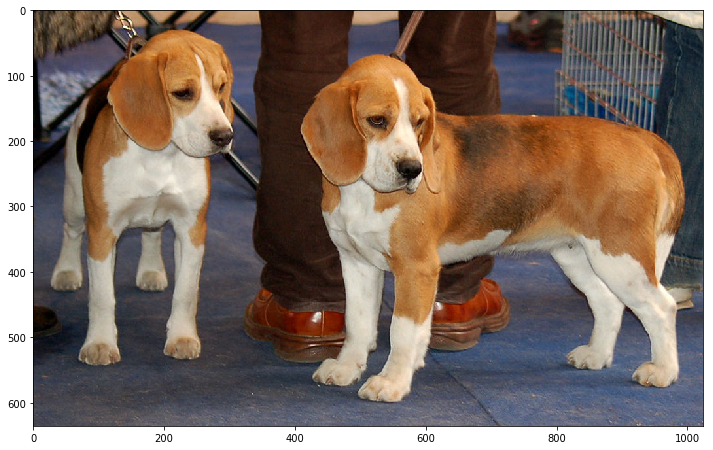

In [75]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  print(image_path)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  #image = imread(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      result_path="/media/sf_VMShared/result/img.png",
      testimg=image_np,
      boxes=output_dict['detection_boxes'],
      classes=output_dict['detection_classes'],
      scores=output_dict['detection_scores'],
      category_index= category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=2)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)